In [386]:
import imp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display
import time

import properties as prop
import random_initialization as rand_init
import matrixes as ma
import interblock_matrixes as i_ma
import utils as u
import reservoir as res
import matrix_initialization as ma_init

imp.reload(prop)
imp.reload(rand_init)
imp.reload(ma)
imp.reload(i_ma)
imp.reload(u)
imp.reload(res)
imp.reload(ma_init)

const = prop.Constants()

In [387]:
def f(x):
    return 2 * x

In [388]:
x = np.array([[1, 2,3],
              [4, 5, 6]
             ])
myfunc_vec = np.vectorize(f)
result = myfunc_vec(x)
result

array([[ 2,  4,  6],
       [ 8, 10, 12]])

In [389]:
nx , ny = 15, 15

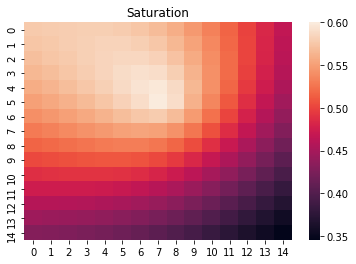

In [390]:
Satur_matrix = ma_init.get_matrix_with_pdf(nx=nx, ny=ny, pdf=ma_init.corner)
Satur_matrix *= 0.6
sns.heatmap(Satur_matrix)
plt.title("Saturation")
plt.show()

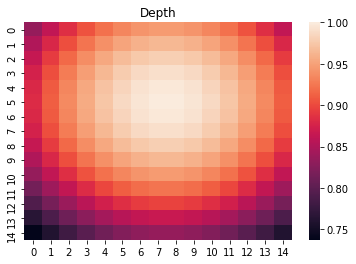

In [391]:
depth_matrix = ma_init.get_matrix_with_pdf(nx=nx, ny=ny, pdf=ma_init.centroid)
sns.heatmap(depth_matrix)
plt.title("Depth")
plt.show()

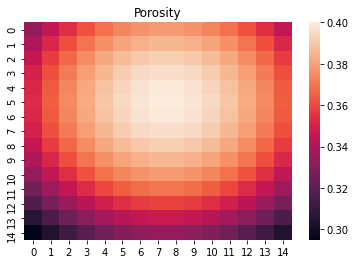

In [392]:
porosity_matrix = ma_init.get_matrix_with_pdf(nx=nx, ny=ny, pdf=ma_init.centroid)
porosity_matrix *= 0.4
sns.heatmap(porosity_matrix)
plt.title("Porosity")
plt.show()

$poirosity\leq 40\%$

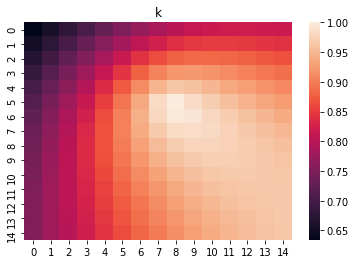

In [393]:
k_matrix = ma_init.get_matrix_with_pdf(nx=nx, ny=ny, pdf=ma_init.corner_1)
sns.heatmap(k_matrix)
plt.title("k")
plt.show()

Давления пусть будут одинаково распределены

In [394]:
dy = np.ones(ny) * const.dy()
dx = np.ones(nx) * const.dx()

p_vec = np.ones((nx*ny)).reshape((-1, 1)) * const.p_0()
S_o_vec = Satur_matrix.reshape((-1, 1))
S_w_vec = (np.ones(Satur_matrix.shape) - Satur_matrix).reshape((-1, 1))

Обозначем важные прмежуточные матрицы для 
$$\vec{p^{n+1}} = \vec{p^{n}} + \Delta t \big[B^{p, w}\big]^{-1}\big[ T^{upd}_{\tilde{k}} \vec{p} + \tilde{Q} + \frac{B_o}{B_w} q_o^{well} + q_w^{well}\big]$$

In [395]:
wells = {}
const_p_wells = {(3, 3): 1,
                 (11, 11): 0.1
        }
neibours = [(9, 9)]

In [396]:
env = res.Env(k_2d_matrix=k_matrix, poir_2d_matrix=porosity_matrix, depth_2d_matrix=depth_matrix,
              satur_2d_matrix=Satur_matrix,
              const=const, well_positions=wells, two_d_well_index_rw_scale=const_p_wells,
              boundary_cond = 'const_pressure'
             )

In [397]:
n_it = int(1e4)
upd_plot_freq = int(1.2e2)
q_o_rate = []
q_w_rate = []
s_o_matrix_history = []

s_o_hist = {key: [] for key in const_p_wells}
s_w_hist = {key: [] for key in const_p_wells}
for key in neibours:
    s_o_hist[key] = []
    s_w_hist[key] = []

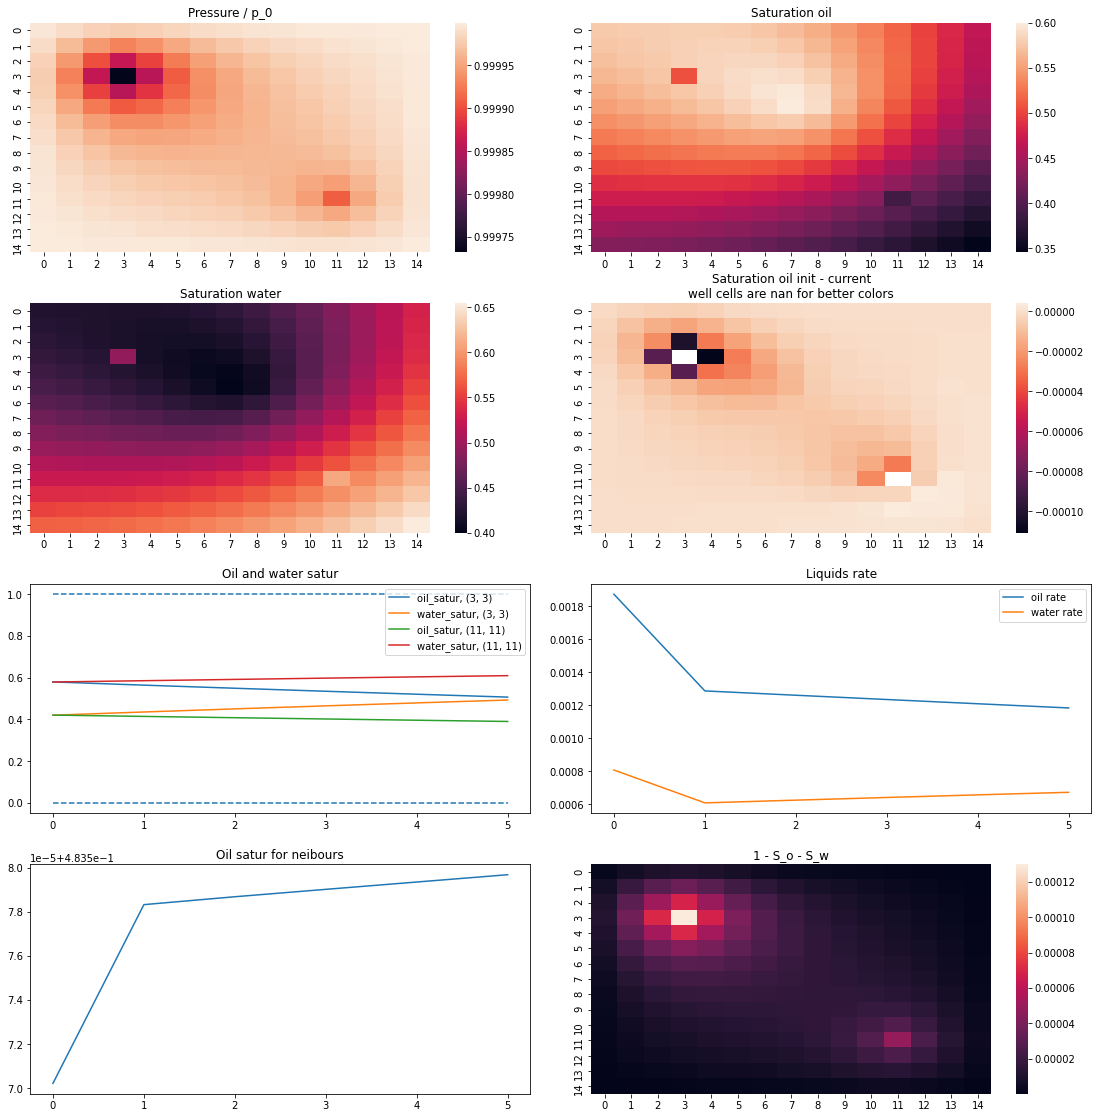

In [ ]:
u.plot_env_state_and_hist(n_it=n_it, upd_plot_freq=upd_plot_freq, env=env, q_w_rate=q_w_rate, q_o_rate=q_o_rate,
                          const_p_wells=const_p_wells, s_o_hist=s_o_hist, s_w_hist=s_w_hist,
                          s_o_matrix_history=s_o_matrix_history, neibours=neibours,
                          saturation_matrix_0=Satur_matrix, const=const, nx=nx, ny=ny)

In [ ]:
env.set_wells_radius_ratio({(3, 3): 0.1, (11, 11): 1})

In [ ]:
u.plot_env_state_and_hist(n_it=n_it, upd_plot_freq=upd_plot_freq, env=env, q_w_rate=q_w_rate, q_o_rate=q_o_rate,
                            const_p_wells=const_p_wells, s_o_hist=s_o_hist, s_w_hist=s_w_hist, neibours=neibours,
                            saturation_matrix_0=Satur_matrix, const=const, nx=nx, ny=ny)

In [ ]:
env.set_wells_radius_ratio((3, 3): 1, (11, 11): 0.1)

In [ ]:
u.plot_env_state_and_hist(n_it=int(5e4), upd_plot_freq=upd_plot_freq, env=env, q_w_rate=q_w_rate, q_o_rate=q_o_rate,
                            const_p_wells=const_p_wells, s_o_hist=s_o_hist, s_w_hist=s_w_hist, neibours=neibours,
                            saturation_matrix_0=Satur_matrix, const=const, nx=nx, ny=ny)